### To Do:
* Build Efficient Frontier Visualizations
* Figure out no short-sell constraint
* Get Risk Free Rate
* Build Fama-French Portfolio Evaluator

In [78]:
import pandas as pd
import datetime as dt
import requests
import json
import csv

import pandas_datareader.data as pdr
import quandl

from sqlalchemy import create_engine
from IPython.display import clear_output as cls

import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
from scipy.optimize import minimize

import time

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
spy_url = "https://us.spdrs.com/site-content/xls/SPY_All_Holdings.xls?fund=SPY&docname=All+Holdings&onyx_code1=&onyx_code2="
spy_holdings = pd.read_excel(spy_url)
spy_holdings.columns = spy_holdings.iloc[2]
access_date = spy_holdings.iloc[1]['Identifier']
spy_holdings.rename({'Weight':'Wt '+access_date,
                     'Shares Held': 'Shares '+access_date,
                     'Identifier' : 'Ticker'},axis=1,inplace=True)
spy_holdings = spy_holdings.iloc[3:].reindex()

top = 100
spy_top = list(spy_holdings.head(top)['Ticker'])
spy_top.append('SPY')

In [57]:
# Query Parameters

tickers = spy_top

if 'VTI' not in tickers and 'SPY' not in tickers:
    tickers.append('VTI')

start = dt.datetime(2000,1,1)
end = dt.datetime.today()

### Get Data

[Alpha Vantage API documentation](https://www.alphavantage.co/documentation/)

In [ ]:
STOP

In [69]:
############## Parameters ##############

alphvan_key = "4X35DPOWF8QL5X42"
url = 'https://www.alphavantage.co/query'
data_freq = 'Daily'.upper()

############## Fetching Code ##############
t0 = time.time()

for i in range(0,len(tickers),30):
    
    ts = tickers[i:i+30]
    fetch_dict = dict()
    
    for ticker in ts:
        if ticker in av_data.keys():
            print(ticker, 'already in av_data')
            print('--'*5)
            continue
            print('should not see this')
        else:
            print('Fetching:',ticker+'...')
            parameters = {
                'function' : 'TIME_SERIES_{freq}_ADJUSTED'.format(
                    freq=data_freq),
                'symbol' : ticker,
                'apikey' : alphvan_key,
                'outputsize' : 'full',
                #'outputsize' : 'compact',        
                'datatype' : 'json'
                  }

            resp = requests.get(url,params=parameters).json()

            if data_freq != 'DAILY':
                series_col = '{freq} Adjusted Time Series'.format(
                    freq=data_freq.title())
            elif data_freq == 'DAILY':
                series_col = 'Time Series ({freq})'.format(
                    freq=data_freq.title())
            alph_van = pd.DataFrame(resp[series_col]).transpose()

            alph_van.index = pd.DatetimeIndex(alph_van.index)
            alph_van = alph_van.astype(float)
            fetch_dict[ticker] = alph_van
            
            print(ticker,'fetched')
            print('--'*5)
            
    av_data.update(fetch_dict)
    print('Tickers in av_data:',len(av_data))
    
    if len(fetch_dict) == 0:
        continue
    elif len(fetch_dict) >= 20:
        t1 = time.time()
        print('#'*15)
        print('Running for:',round((t1-t0)/60,2),'minutes')
        print('Sleep...')
        time.sleep(15)
        print('Wake up now!')
        print('='*15)

t2 = time.time()
print('Number of Tickers in av_data:',len(av_data))
print('Time required:',round((t2-t0)/60,2),'minutes')
print('#'*10,'ALPHA ADVANTAGEtest.sum(axis=0) FETCH COMPLETE','#'*10)

price_key = '5. adjusted close'


AAPL already in av_data
----------
MSFT already in av_data
----------
AMZN already in av_data
----------
FB already in av_data
----------
BRK.B already in av_data
----------
JPM already in av_data
----------
JNJ already in av_data
----------
GOOG already in av_data
----------
GOOGL already in av_data
----------
XOM already in av_data
----------
BAC already in av_data
----------
INTC already in av_data
----------
WFC already in av_data
----------
CVX already in av_data
----------
V already in av_data
----------
T already in av_data
----------
PFE already in av_data
----------
UNH already in av_data
----------
CSCO already in av_data
----------
HD already in av_data
----------
VZ already in av_data
----------
PG already in av_data
----------
C already in av_data
----------
BA already in av_data
----------
ABBV already in av_data
----------
MA already in av_data
----------
KO already in av_data
----------
CMCSA already in av_data
----------
DWDP already in av_data
----------
PEP already i

<function __main__.<lambda>>

In [82]:
# Connect to the MySQL, but without selecting a database
conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user     = 'root', 
    password = input('Password'), 
    host     = '127.0.0.01', 
    port     = 3306, 
    encoding = 'utf-8'
)
engine = create_engine(conn_string)
cls()

In [84]:

pd.read_sql('SHOW databases',con=engine)

OperationalError: (_mysql_exceptions.OperationalError) (1045, "Access denied for user 'root'@'localhost' (using password: YES)") (Background on this error at: http://sqlalche.me/e/e3q8)

[Quandl API documentation](https://docs.quandl.com/docs/data-organization)

Pandas Datareader

### Consolidate Prices

In [9]:
def merge_prices(data_dict,price_key,cut_off,
                 start_date=start,end_date=end):

    """Returns adj. close prices of queried stocks"""

    data = data_dict
    dates = pd.date_range(start=start_date, end=end_date)
    prices = pd.DataFrame(index=dates)

    for ticker in data.keys():
        if len(data[ticker]) >= cut_off:
            price_col =  pd.DataFrame(
                data[ticker][price_key]
            ).rename({price_key:ticker},axis=1)

            prices = pd.merge(prices,price_col,
                             how='outer',
                             left_index=True,right_index=True)
        else:
            continue
    return prices.dropna()

In [10]:
def get_prices(data = av_data,years=10,months=0,days=0):
    if data_freq == 'DAILY':
        cut_off = 365*years+30*months+days
    elif data_freq == 'WEEKLY':
        cut_off = 12*4*years+4*months
    elif data_freq == 'MONTHLY':
        cut_off = 12*years+months

    prices = merge_prices(data,price_key,cut_off)
    return prices

In [11]:
prices = get_prices()

In [12]:
def get_returns(data=av_data,period='D'):

    period = period[0].upper()
    prices = get_prices(data)
    
    returns_data = prices.resample(period).first().pct_change().dropna()
    
    annualize = {'A' : 1,'Q' : 4,'M' : 12,'W' : 12*4,'D' : 365}
    global ann_factor
    ann_factor = annualize[period]

    return returns_data

In [13]:
# Set default returns series
rsample = 'W'
returns = get_returns(period=rsample)

### Data Analysis and Visualization

In [14]:
# Number of Stocks
len(returns.columns)

89

In [15]:
# Days in returns
returns_dates = returns.index
print('Data Start:',str(returns_dates[0].date()))
print('Data End:',str(returns_dates[-1].date()))
print(str(returns_dates[-1]-returns_dates[0]))

Data Start: 2002-12-15
Data End: 2018-03-25
5579 days 00:00:00


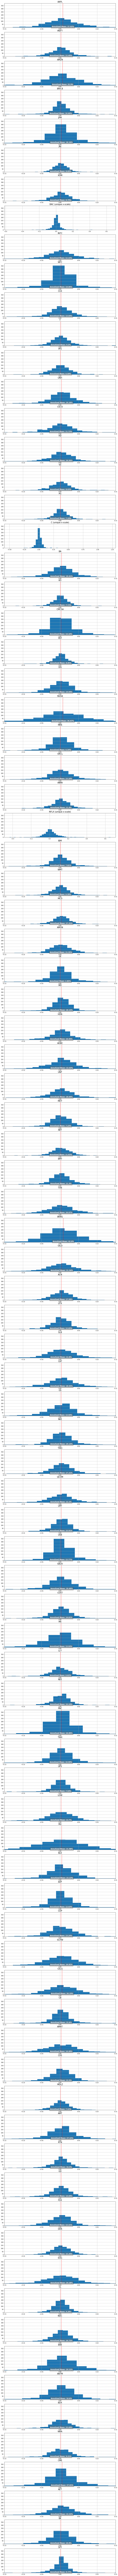

In [32]:
# Returns Histograms
cols = returns.columns

fig, ax = plt.subplots(nrows = len(cols),ncols=1,
                       figsize=(15,len(cols)*4),
                       sharey=True,sharex=False)

min_std = returns.min().std()
min_mean = returns.min().mean()
max_std = returns.max().std()
max_mean = returns.max().mean()

plt.title('Mean Returns Distribution')

for i in range(len(cols)):
    
    stock = returns[cols[i]]
    
    min_sigma = abs(stock.min() - min_mean) / min_std
    max_sigma = abs(stock.max() - max_mean) / max_std
    
    if max_sigma < 1.5 or min_sigma < 1.5:
        stock.hist(bins = 25,ax=ax[i])
        ax[i].set_title(cols[i],fontsize=15)

        mean = stock.mean()
        ax[i].axvline(mean,c='red',linestyle='--')
        ax[i].text(mean,5,
                   'Annulized Mean: {m}%'.format(
                       m=str(round(mean*ann_factor*100,2))),
                   ha='center', color='w',
                   fontsize=12,fontweight ='bold',
                   bbox={'facecolor':'gray', 'alpha':0.5, 'pad':5})
        ax[i].set_xlim(-.15,.15)
    else:
        returns[cols[i]].hist(bins = 50,ax=ax[i])
        ax[i].set_title(cols[i]+' (unique x-scale)',fontsize=15)

In [17]:
# normalized price growth
normalized = prices / prices.iloc[0]
if len(cols) <= 10:
    normalized.plot(figsize=(12,8))
    plt.show()

In [18]:
# Annualized Returns, St.Dev., Sharpe Ratio
gd_r = returns.mean()*ann_factor
gd_std = returns.std()*np.sqrt(ann_factor)
gd_summary = pd.DataFrame({
        'Mean':gd_r,
        'Standard Deviation' : gd_std,
        'Sharpe Ratio' : gd_r/gd_std,
        'Skewness' : returns.skew(),
        'Kurtosis' : returns.kurt()
    }).sort_values('Sharpe Ratio',ascending=False,axis = 0)

display(gd_summary[['Mean','Standard Deviation','Sharpe Ratio',
           'Skewness','Kurtosis']].head(10))
display(gd_summary[['Mean','Standard Deviation','Sharpe Ratio',
           'Skewness','Kurtosis']].tail(10))

,Mean,Standard Deviation,Sharpe Ratio,Skewness,Kurtosis
AAPL,0.370172,0.334478,1.106717,0.115748,1.692206
MCD,0.173127,0.181228,0.955301,-0.075491,2.129788
MO,0.181331,0.191274,0.948018,0.575731,10.348583
BKNG,0.419973,0.446802,0.939953,1.525465,10.873403
AMT,0.273246,0.291868,0.936198,0.510011,5.951633
NFLX,0.529688,0.583128,0.908356,0.578871,7.253177
RTN,0.165009,0.193964,0.850720,-0.062527,3.003825
AMZN,0.328959,0.389860,0.843788,0.713850,5.167039
BDX,0.150911,0.185937,0.811621,-0.037087,2.284445
NEE,0.151929,0.187657,0.809614,-0.041058,4.629621


,Mean,Standard Deviation,Sharpe Ratio,Skewness,Kurtosis
WMT,0.063870,0.172901,0.369401,-0.060993,2.746968
BK,0.108951,0.311720,0.349517,0.392994,7.580187
MDT,0.072348,0.217586,0.332501,-0.519316,5.150517
PFE,0.065931,0.208632,0.316014,0.064120,2.953678
MS,0.139262,0.442909,0.314427,0.960736,11.266226
LLY,0.066208,0.212400,0.311714,-0.121243,2.860388
BAC,0.140992,0.488042,0.288894,0.998466,21.245344
MRK,0.063434,0.241065,0.263140,-0.243542,7.468786
GE,0.028471,0.263417,0.108082,0.403230,8.647943
C,0.055214,0.547325,0.100880,4.244902,76.301912


In [19]:
# Correlation Matrix
returns.corr().head()

,AAPL,MSFT,AMZN,BRK.B,JPM,JNJ,XOM,BAC,INTC,WFC,...,CL,NOC,BIIB,ANTM,BDX,WBA,CME,AET,BK,SPY
AAPL,1.000000,0.407777,0.386219,0.258891,0.366622,0.248987,0.345450,0.310172,0.428108,0.304371,...,0.219275,0.281215,0.196939,0.225075,0.255608,0.253020,0.327727,0.251255,0.414819,0.543906
MSFT,0.407777,1.000000,0.460620,0.336877,0.429609,0.373669,0.403260,0.387929,0.538677,0.418319,...,0.321426,0.427695,0.264509,0.267249,0.366116,0.365429,0.443756,0.341048,0.469725,0.655317
AMZN,0.386219,0.460620,1.000000,0.274429,0.353712,0.251379,0.268724,0.315514,0.396501,0.346124,...,0.285357,0.275614,0.233283,0.230576,0.321748,0.280333,0.345634,0.328672,0.381221,0.510695
BRK.B,0.258891,0.336877,0.274429,1.000000,0.564795,0.389751,0.373768,0.573803,0.348127,0.577426,...,0.327165,0.439573,0.287093,0.295387,0.300938,0.367108,0.363657,0.298132,0.459736,0.615795
JPM,0.366622,0.429609,0.353712,0.564795,1.000000,0.397551,0.436061,0.817743,0.484355,0.833442,...,0.294733,0.403168,0.326571,0.328457,0.339442,0.395181,0.524576,0.378753,0.729933,0.738973


### Portfolio Optimization

In [20]:
def get_portfolio(weights,data=returns,
              param='sharpe_ratio',opt=False):

    port_wt = pd.DataFrame({'weights':weights},
                        index=returns.columns).transpose()

    cov = data.cov()

    partials = port_wt.dot(cov)*port_wt
    partials.rename({'weights':'Partials'},
                    axis = 0,inplace=True)

    port_var = partials.sum(axis=1)[0]

    port_std = np.sqrt(port_var)

    port_return = (data.mean()*port_wt).sum(axis=1)[0]

    sharpe_ratio = port_return/port_std
    
    
    param = param[:2].lower()
    
    if param not in ['sh','sr','va','re','st','we']:
        new_param = input("""Choose param options:\n
        sharpe_ratio,\n
        variance,\n
        standard_deviation,\n
        returns,or\n
        weights\n""")
        
        param = new_param[:2].lower()
    if param in ['sh', 'sr']:
        if opt==False:
            return sharpe_ratio
        elif opt==True:
            return -sharpe_ratio
        
    elif param == 'va':
        return port_var
    
    elif param == 're':
        if opt==False:
            return port_return
        elif opt==True:
            return -port_return
        
    elif param == 'st':
        return port_std
    
    elif param =='we':
        return port_wt
    else:
        print('PORTFOLIO PARAMETER ERROR')

In [21]:
def portfolio_optimize(weights,objective,data):
    return get_portfolio(weights,param=objective,opt=True,data=data)

[Scipy Optimize Reference](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)<br>
[Scipy Optimize Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [22]:
def optimize(objective='sharpe_ratio',
             allow_short=False,data=returns):
    
    cons = [{'type':'eq',
            'fun':lambda x: np.array(sum(x)-1)}]
    # no short constraint where x[i] >= 0

    #initial values    
    x0 = np.array([1/len(data.columns) for n in range(len(data.columns))])
    if allow_short == False:
        res = minimize(portfolio_optimize, x0, args=(objective,data),
                        method='SLSQP',
                        constraints=cons,
                        bounds = [(0,1) for i in range(len(data.columns))],
                        options={'disp': False})
    elif allow_short == True:
        res = minimize(portfolio_optimize, x0, args=(objective,data),
                        method='SLSQP',
                        constraints=cons,
                        bounds = [(-1,1) for i in range(len(data.columns))],
                        options={'disp': False})
    return res.x

In [35]:
def port_returns(data=returns, output_wts = False,
                 opt_obj='sharpe ratio',allow_short=False):

    port_res = get_portfolio(optimize(objective=opt_obj,
                                      data=data,
                                      allow_short=allow_short),
                             param='weights', data=data)
    
    for col in port_res.columns:
        if abs(port_res.loc['weights'][col]) < 0.001:
            port_res.loc['weights'][col] = 0
    port_res=port_res.loc[
        :,port_res.loc['weights'] != 0]
    port_tickers = port_res.columns
    port_returns = data[port_tickers]*port_res.loc['weights']
    
    port_returns['portfolio'] = port_returns.sum(axis=1)
    if output_wts == False:
        return port_returns
    elif output_wts == True:
        return port_returns, port_res

In [36]:
port_returns(output_wts=True,
             allow_short=False,
             opt_obj='sr')[1].sort_values(
    'weights',axis=1,ascending=False)

,MO,AAPL,MCD,RTN,NFLX,NEE,BKNG,CELG,CME,BDX,GILD,AET
weights,0.250622,0.176578,0.139649,0.09232,0.089046,0.081497,0.072704,0.057416,0.017642,0.009258,0.007282,0.005987


In [37]:
port_returns(output_wts=True,
             allow_short=False,opt_obj='sr')[1].sum(axis=1)

weights    1.0
dtype: float64

In [26]:
port_weights = port_returns(output_wts=True,
                            allow_short=True,
                            opt_obj='sr'
                           )[1].transpose().sort_values(
    'weights',ascending=False)

display(port_weights.head(10).transpose())
display(port_weights.tail(10).transpose())

,MO,MCD,AAPL,JNJ,RTN,PEP,NEE,EOG,NOC,JPM
weights,0.266314,0.247544,0.209949,0.20913,0.19475,0.191653,0.187602,0.140941,0.140787,0.131996


,LLY,AXP,CL,IBM,GD,C,PFE,GE,BK,SPY
weights,-0.093901,-0.099129,-0.109058,-0.113528,-0.119572,-0.122064,-0.137732,-0.184593,-0.201438,-1.0


In [27]:
port_weights.sum(axis=0)

weights    1.0
dtype: float64

### Portfolio Set & Efficient Frontier

In [28]:
max_sr = port_returns(opt_obj='sr')['portfolio']
min_var = port_returns(opt_obj='std')['portfolio']

sr_var = pd.DataFrame({'max_sr':max_sr,'min_var':min_var})

decimals = 2
dn = 10**decimals
rm = 5
wts1 = [n/dn for n in range(-rm*dn,rm*dn+1)]
wts2 = [1-wt for wt in wts1]
port_choice = pd.DataFrame({'max_sr' : wts2, 'min_var': wts1})

port_choice['r'] = (port_choice['max_sr']*max_sr.mean() +
                          port_choice['min_var']*min_var.mean())
cov = sr_var.cov()
sv_var = list()
for i in port_choice.index:
    mar_var_wt = pd.DataFrame(port_choice[['max_sr', 'min_var']]
                      .loc[i]).transpose()
    joint_var = mar_var_wt.dot(cov)*mar_var_wt
    joint_var = joint_var.sum(axis=1).iloc[0]
    sv_var.append(joint_var)
port_choice['var'] = sv_var
port_choice['std'] = np.sqrt(port_choice['var'])

port_choice[['r','var']] = port_choice[
    ['r','var']]*ann_factor

port_choice['std'] = np.sqrt(port_choice['var'])
port_choice['sr'] = port_choice['r']/port_choice['std']

min_var_port = port_choice['std'] == port_choice['std'].min()
min_var_port = port_choice[min_var_port]

eff_portfolios = port_choice['min_var'] <= float(
    min_var_port['min_var'])
eff_front = port_choice[eff_portfolios]

max_sr_port = port_choice['sr'] == port_choice['sr'].max()
max_sr_port = port_choice[max_sr_port]

In [29]:
# eff_choices not min_var? Issue with optimizer?
min_var_port

,max_sr,min_var,r,var,std,sr
608,-0.08,1.08,0.09497,0.011582,0.107622,0.882439


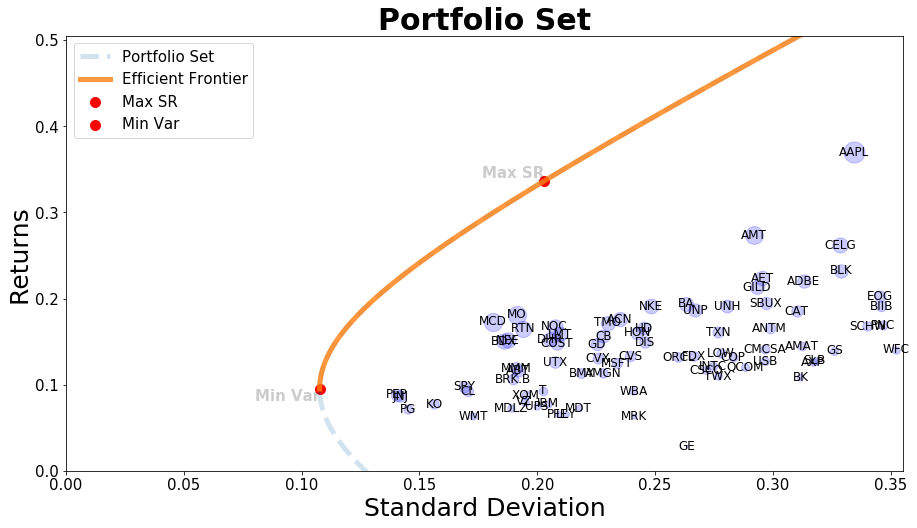

In [30]:
fig,ax = plt.subplots(figsize=(15,8))

max_r = float(max_sr_port['r'])*1.5
max_var = float(max_sr_port['std'])*1.75

port_choice.plot('std','r', label = 'Portfolio Set',
                 linestyle='--',lw = 5, # marker='o', mew=5,
                 #s=10,
                 alpha = .2,
                 ax = ax)

eff_front.plot('std','r', label = 'Efficient Frontier',
               linestyle='-',lw = 5,
               alpha = 0.8,
               ax = ax
              )
def plot_stocks():
    for ticker in returns.columns:
        ann_r = returns.mean()[ticker]*ann_factor
        ann_std = returns.std()[ticker]*np.sqrt(ann_factor)
        if ann_r < max_r and ann_std < max_var:
            ax.scatter(ann_std,ann_r,
                      s = 1000*((ann_r/ann_std)/max_sr_port['sr'])**2,
                       color = 'b',
                      alpha = .2)
            ax.text(ann_std,ann_r,ticker,fontsize=12,
                    va='center',ha='center')
        else:
            continue

plot_stocks() # Plot
        
ax.scatter(float(max_sr_port['std']),float(max_sr_port['r']),
          alpha = 1, s = 100,c='red',label='Max SR')
ax.text(float(max_sr_port['std']),float(max_sr_port['r']),
        'Max SR',size=15,fontweight='bold',
         alpha = .2, va='bottom',ha='right')

ax.scatter(float(min_var_port['std']),float(min_var_port['r']),
          alpha = 1, s = 100,c='red',label='Min Var')
ax.text(float(min_var_port['std']),float(min_var_port['r']),
        'Min Var',size=15,fontweight='bold',
         alpha = .2,va='top',ha='right')
    
ax.set_title('Portfolio Set',fontsize=30,fontweight='bold')
ax.set_xlabel('Standard Deviation',fontsize = 25)
ax.set_ylabel('Returns',fontsize = 25)
ax.tick_params(axis='both',labelsize=15)

ax.set_ylim((0,max_r))
ax.set_xlim((0,max_var))

ax.legend(fontsize=15)

plt.show()